In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import yfinance as yf

In [2]:
sns.set_theme()

In [3]:
investment = 10_000


In [4]:
strategies = ['RF', 'S1', 'S2', 'S3', 'S4a', 'S4b', 'S4c']

In [2]:
def get_decade(x, d):
    return x.loc[str(d): str(d+9)].copy()

In [6]:
def calc_strat_4(r, n=1):
    r_all = []
    for y in r.index.year.unique():
        r_year = r.loc[str(y)].copy()
        nsmallest_indices = r_year.nsmallest(n=n).index
        nlargest_indices = r_year.nlargest(n=n).index
        r_year.loc[nsmallest_indices] = 0
        r_year.loc[nlargest_indices] = 0
        r_all.append(r_year)

    return pd.concat(r_all)

In [7]:
def calc_stats(x):
    x_rf = x.sub(x['RF'], axis=0)
    return pd.concat(
        objs=[
            x.mean().mul(252),
            x.std().mul(np.sqrt(252)),
            np.sqrt(252) * x_rf.mean() / x_rf.std()
        ],
        keys=['mean', 'std', 'sharpe'],
        names=['Statistic'],
        axis=1
    )

In [8]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    df = (
        yf.download(tickers='SPY')
        .join(pdr.DataReader(
                name='F-F_Research_Data_Factors_daily',
                data_source='famafrench',
                start='1900'
            )
            [0]
            .div(100)
        )
        .assign(
            r=lambda x: x['Adj Close'].pct_change(),
            S1=lambda x: x['r'],
            S2=lambda x: x['Close'] / x['Open'] - 1,
            S3=lambda x: (1 + x['r']) / (1 + x['S2']) - 1,
            S4a=lambda x: calc_strat_4(r=x['r'], n=1),
            S4b=lambda x: calc_strat_4(r=x['r'], n=2),
            S4c=lambda x: calc_strat_4(r=x['r'], n=3),
        )
    )

[*********************100%%**********************]  1 of 1 completed


In [9]:
returns = df[strategies].dropna().rename_axis(columns='Strategy')
returns_tot = returns.add(1).prod().sub(1)
returns_cum = returns.add(1).cumprod().sub(1)

stats = returns.pipe(calc_stats)
decades = ((returns.index.year // 10 ) * 10).unique().to_list()
stats_dec = pd.concat(
    objs=[returns.pipe(get_decade, d=d).pipe(calc_stats) for d in decades],
    keys=decades,
    names=['Decade']
)


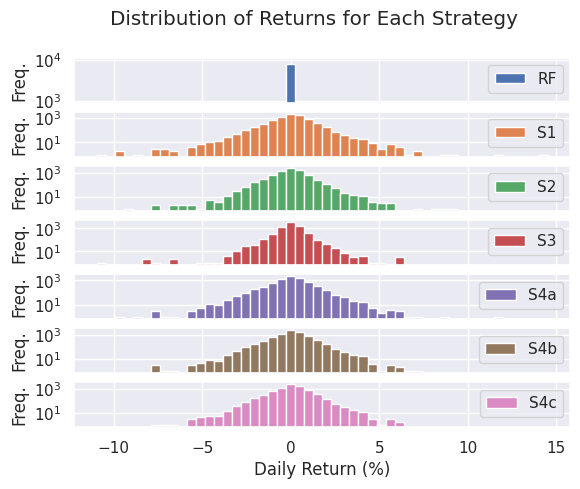

In [11]:
axes = returns.mul(100).plot(kind='hist', bins=50, logy=True, subplots=True)
for ax in axes:
    ax.set_ylabel('Freq.')
plt.xlabel('Daily Return (%)')
plt.suptitle('Distribution of Returns for Each Strategy')
plt.show()


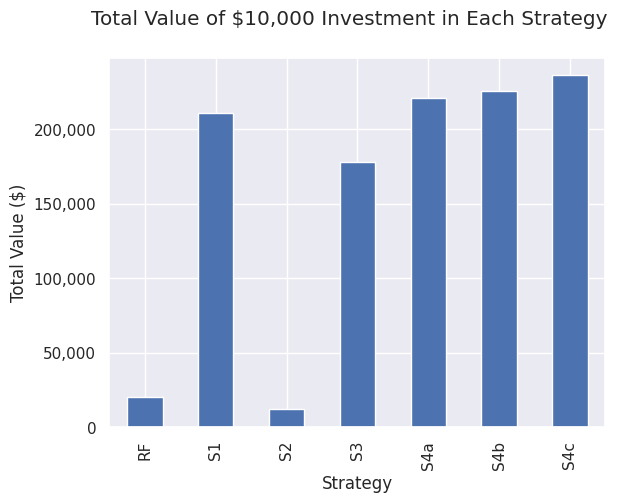

In [13]:
returns_tot.add(1).mul(investment).plot(kind='bar')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Total Value ($)')
plt.suptitle(f'Total Value of ${investment:,.0f} Investment in Each Strategy')
plt.show()

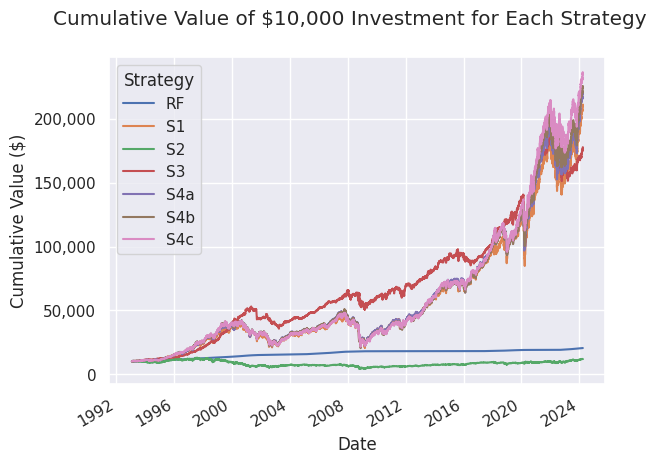

In [14]:
returns_cum.add(1).mul(investment).plot()
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.ylabel('Cumulative Value ($)')
plt.suptitle(f'Cumulative Value of ${investment:,.0f} Investment for Each Strategy')
plt.show()

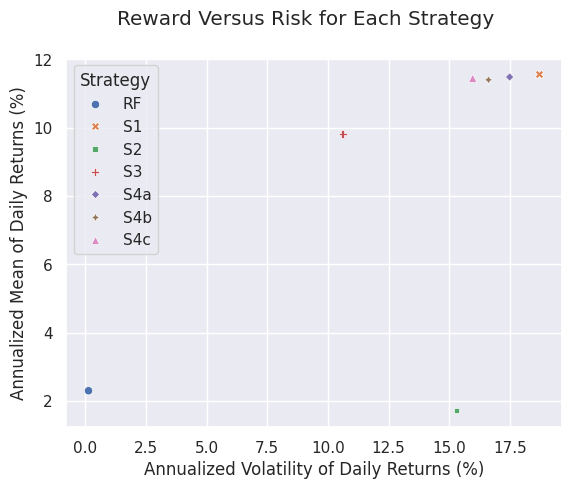

In [15]:
(
    returns
    .pipe(calc_stats)
    .mul(100)
    .reset_index()
    .pipe(
        sns.scatterplot,
        x='std',
        y='mean',
        hue='Strategy',
        style='Strategy',
    )
)

plt.xlabel('Annualized Volatility of Daily Returns (%)')
plt.ylabel('Annualized Mean of Daily Returns (%)')
plt.suptitle('Reward Versus Risk for Each Strategy')
plt.show()

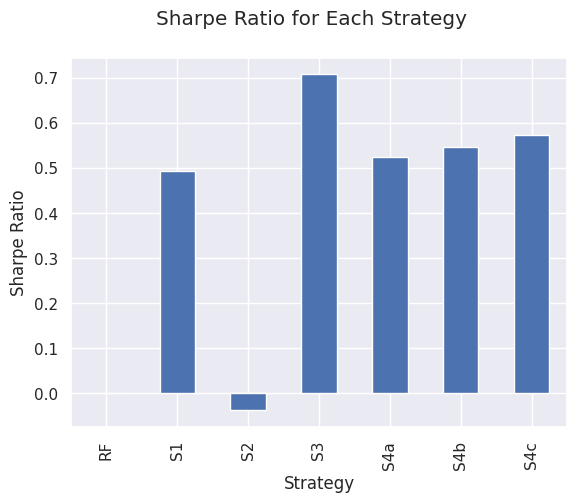

In [16]:
stats['sharpe'].plot(kind='bar')
plt.ylabel('Sharpe Ratio')
plt.suptitle(f'Sharpe Ratio for Each Strategy')
plt.show()

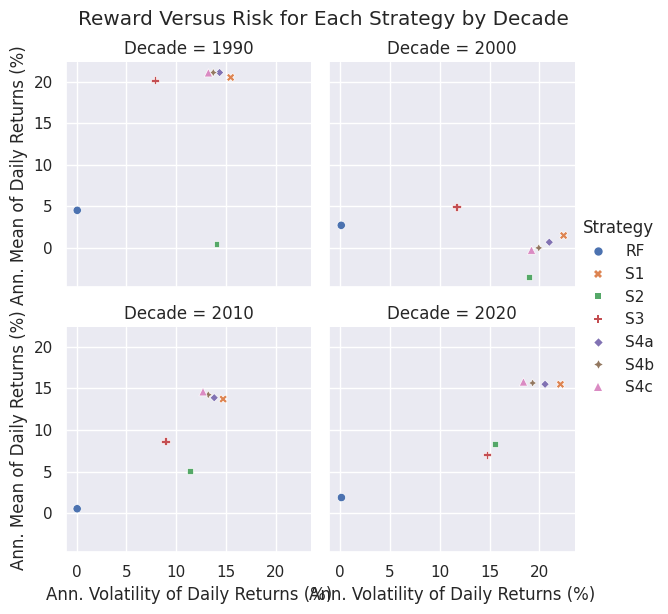

In [17]:
(
    stats_dec
    .mul(100)
    .reset_index()
    .rename(columns={
        'mean': 'Ann. Mean of Daily Returns (%)',
        'std': 'Ann. Volatility of Daily Returns (%)'
    })
    .pipe(
        sns.relplot,
        x='Ann. Volatility of Daily Returns (%)',
        y='Ann. Mean of Daily Returns (%)',
        hue='Strategy',
        style='Strategy',
        col='Decade',
        col_wrap=2,
        height=3
    )
)

plt.suptitle('Reward Versus Risk for Each Strategy by Decade', y=1.02)
plt.show()

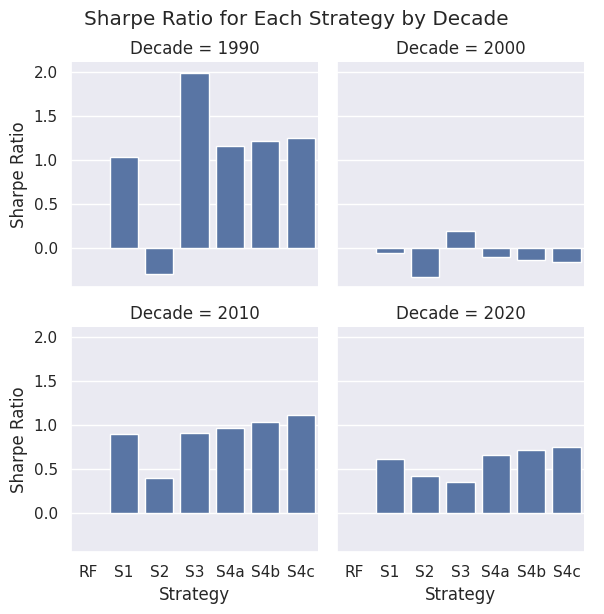

In [18]:
(
    stats_dec
    .reset_index()
    .rename(columns={'sharpe': 'Sharpe Ratio'})
    .pipe(
        sns.catplot,
        y='Sharpe Ratio',
        x='Strategy',
        col='Decade',
        col_wrap=2,
        kind='bar',
        height=3
    )
)

plt.suptitle('Sharpe Ratio for Each Strategy by Decade', y=1.02)
plt.show()